In [3]:
# Import packages
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import os
import dill, sys
import copy
import numpy as np
import matplotlib.pyplot as plt
import scarlet

import statmorph

import kuaizi as kz
from kuaizi.display import display_single, SEG_CMAP, display_scarlet_results_tigress
from kuaizi.detection import Data


import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column, Row

In [6]:
env_dict = {'project': 'HSC', 'name': 'LSBG', 'data_dir': '/tigress/jiaxuanl/Data'}
kz.utils.set_env(**env_dict)
kz.utils.set_matplotlib(style='default', usetex=False)

In [7]:
#### Make measurement

In [8]:
import sys
sys.path.append('/home/jiaxuanl/Research/Packages/kuaizi/diezi/scarlet_modeling/script/')

In [10]:
# from vanilla_measure_all import measure_vanilla
from kuaizi.measure import initialize_meas_cat, makeMeasurement
from tqdm import trange

In [90]:
lsbg_cat = Table.read('/scratch/gpfs/jiaxuanl/Data/HSC/LSBG/Catalog/mock_sample/mock_gal_param_truth.fits')
lsbg_cat.sort('viz-id')

In [12]:
meas_cat = initialize_meas_cat(lsbg_cat)

In [11]:
for i in trange(200):
    measure_vanilla(i, lsbg_cat, meas_cat, 
                    '/tigress/jiaxuanl/Data/HSC/LSBG/Model/mock_sample/', 
                    'mock', 
                    method='vanilla', 
                    makesegmap=False)

100%|██████████| 200/200 [05:41<00:00,  1.71s/it]


In [12]:
meas_cat.write('./Catalog/mock_sample/mock_measure_vanilla_nosegmap_all.fits', overwrite=True)

In [76]:
### Galsim sersic_half_light_radius = rhalf_circularized, after PSF deconvolution

In [97]:
from kuaizi.measure import cal_mu0, cal_mue, fn

In [116]:
cal_mue(lsbg_cat['sersic_n'][idx], 
        lsbg_cat['sersic_rhalf_circ'][idx], 
        lsbg_cat['mags'][idx][0]) - 2.5 * np.log10(fn(lsbg_cat['sersic_n'][idx]))

23.36955565383528

In [115]:
meas_cat['SB_eff_avg'][idx]

array([24.08226967, 23.60842514, 23.36719322, 23.29233932])

In [ ]:
array([102, 126, 127, 128, 137, 141, 142, 167, 183, 197])

In [130]:
ind = 12

[<AxesSubplot:title={'center':'Background'}>,
 <AxesSubplot:title={'center':'Mock Image'}>,
 <AxesSubplot:title={'center':'Model'}>]

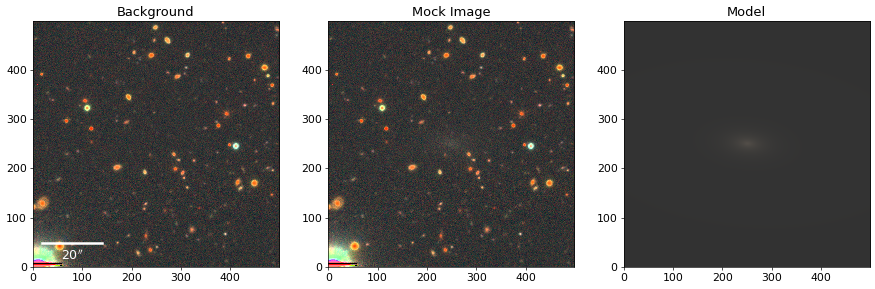

In [131]:
import pickle
with open(f'/scratch/gpfs/jiaxuanl/Data/HSC/LSBG/Cutout/mock_sample/mock_{ind}.pkl', 'rb') as fp:
    gal = pickle.load(fp)
    
gal.display()

In [132]:
with open(f'/scratch/gpfs/jiaxuanl/Data/HSC/LSBG/Model/mock_sample/mock-{ind}-trained-model-wavelet.df', "rb") as fp:
    blend, info, mask = dill.load(fp)
    fp.close()

[<AxesSubplot:title={'center':'Data'}>,
 <AxesSubplot:title={'center':'Model'}>,
 <AxesSubplot:title={'center':'Residual'}>]

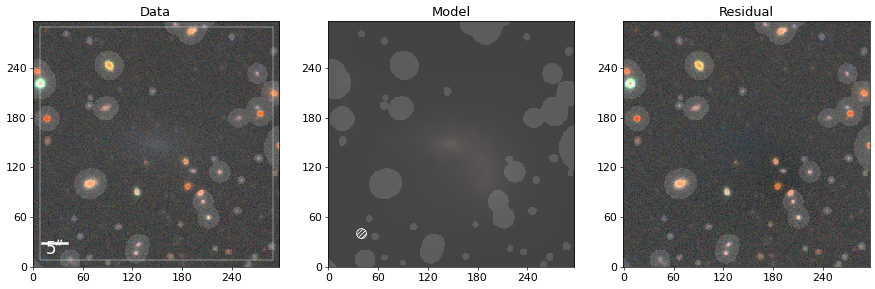

In [133]:
kz.display.display_scarlet_model(
    blend,
    show_ind=[0],
    zoomin_size=50,
    minimum=-0.3,
    stretch=1,
    add_boxes=True,
    channels='griz',
    show_mask=False,
    show_mark=False)

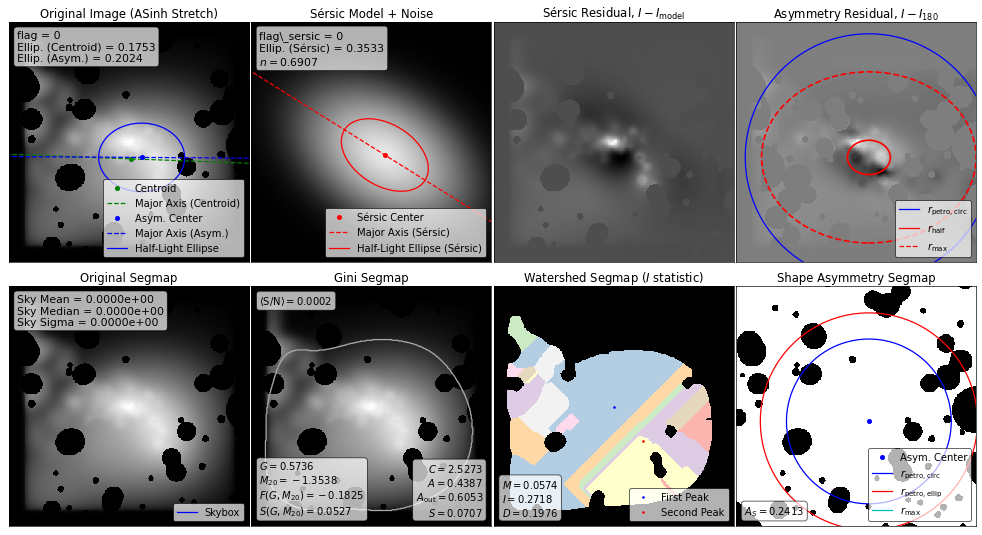

In [134]:
measurement, _ = makeMeasurement(list(np.array(blend.sources)[info['sed_ind']]),
                                 blend.observations[0],
                                 aggr_mask=mask.astype(bool),
                                 makesegmap=False, sigma=0.5,
                                 zeropoint=27.0, out_prefix=None,
                                 show_fig=True, asinh_a=0.02, framealpha=0.7)
#row = _write_to_row(row, measurement)

In [104]:
components = list(np.array(blend.sources)[info['sed_ind']])
observation = blend.observations[0]

In [85]:
min_cutout_size = max([comp.bbox.shape[1] for comp in components])
_blend = scarlet.Blend(components, observation)

if min_cutout_size < 0.9 * observation.bbox.shape[1]:
    # Multi-components enabled
    lower_left = np.min([np.array(comp.bbox.origin)
                        for comp in components], axis=0)
    upper_right = np.max([np.array(comp.bbox.origin) +
                        np.array(comp.bbox.shape) for comp in components], axis=0)
    bbox = scarlet.Box(upper_right - lower_left, origin=lower_left)
   #bbox.center = np.array(bbox.origin) + np.array(bbox.shape) // 2
    _shape = tuple(int(i * 1.15) for i in bbox.shape)
    bbox.origin = tuple(int(bbox.center[i] - _shape[i] // 2) for i in range(3))
    bbox.shape = _shape

In [86]:
bbox

<Box shape=(4, 357, 357), origin=(0, 71, 71)>

In [50]:
models = _blend.get_model()  # PSF-free model
models = observation.render(models)  # PSF-convoled model


In [59]:
_blend.bbox

<Box shape=(4, 499, 499), origin=(0, 0, 0)>

In [135]:
measurement['sersic_rhalf'] * np.sqrt(1 - measurement['sersic_ellip']) * 0.168, measurement['rhalf_circularized'] * 0.168

(8.643848788825048, 8.685793231478533)

In [136]:
lsbg_cat[lsbg_cat['viz-id'] == ind][['rhalf_circularized']]

rhalf_circularized
float64
6.605138832076752


In [125]:
-2.5 * np.log10(measurement['flux_circ']) + 27.0

array([16.987854, 16.573814, 16.384848, 16.201029], dtype=float32)

In [126]:
lsbg_cat[lsbg_cat['viz-id'] == ind]

viz-id,SB_eff_g,mag_g,ellip,sersic_n,g-i,g-r,rhalf_circularized
int64,float64,float64,float64,float64,float64,float64,float64
69,24.53721404066812,16.94854749174686,0.5350126589018843,0.8912165134960663,0.6195692986593739,0.41130416340908843,13.14145268086412


### Comparison with groud truth

In [13]:
from astropy.table import vstack

In [14]:
lsbg_cat = vstack([Table.read('./Catalog/mock_sample/mock_obj_cat_all.fits')])
meas_cat = vstack([Table.read('./Catalog/mock_sample/mock_measure_vanilla_nosegmap_all.fits')])

lsbg_cat['SB_eff_avg_g'] = lsbg_cat['mags'][:, 0] + 2.5 * np.log10(2 * np.pi * lsbg_cat['sersic_rhalf_circ']**2)
meas_cat['mag_circ'] = -2.5 * np.log10(meas_cat['flux_circ']) + 27.0

In [87]:
# flag = lsbg_cat['SB_eff_avg_g'] < 27
# lsbg_cat = lsbg_cat[flag]
# meas_cat = meas_cat[flag]

In [15]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

(array([0.05893949, 0.19646498, 0.36346022, 0.41257646, 0.36346022,
        0.20628823, 0.26522773, 0.06876274, 0.0196465 , 0.00982325]),
 array([0.72539183, 1.23438839, 1.74338495, 2.2523815 , 2.76137806,
        3.27037462, 3.77937118, 4.28836774, 4.79736429, 5.30636085,
        5.81535741]),
 [<matplotlib.patches.Polygon at 0x2af9a598ab90>])

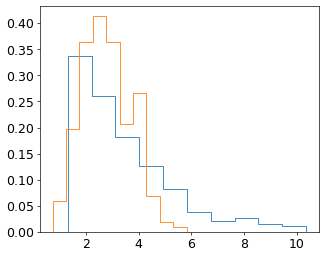

In [16]:
plt.hist(lsbg_cat['sersic_rhalf_circ'], density=True, histtype='step')
plt.hist(meas_cat['rhalf_circularized'] * 0.168, density=True, histtype='step')

In [17]:
from matplotlib import colors

Text(0.5, 0.98, 'Mock Sersic galaxies')

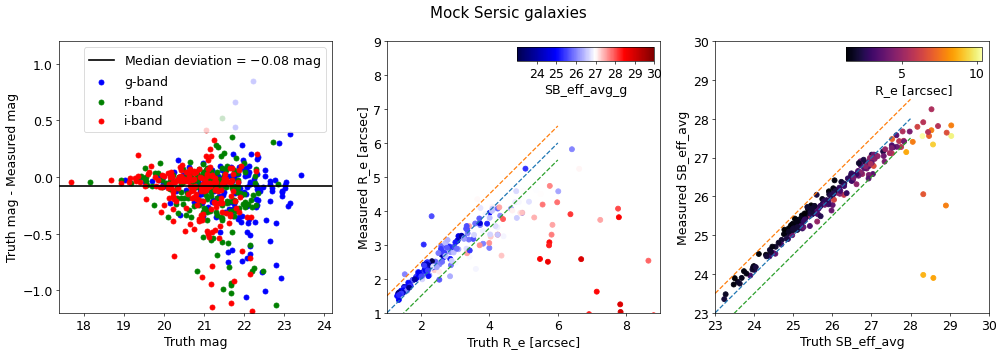

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

plt.sca(axes[0])
plt.scatter(lsbg_cat['mags'][:, 0], 
            lsbg_cat['mags'][:, 0] - meas_cat['mag_circ'][:, 0], color='b', label='g-band')
plt.scatter(lsbg_cat['mags'][:, 1], 
            lsbg_cat['mags'][:, 1] - meas_cat['mag_circ'][:, 1], color='g', label='r-band')
plt.scatter(lsbg_cat['mags'][:, 2], 
            lsbg_cat['mags'][:, 2] - meas_cat['mag_circ'][:, 2], color='r', label='i-band')
#plt.scatter(lsbg_cat['mags'][flag][:, 0], lsbg_cat['mags'][flag][:, 0] - meas_cat[flag]['mag_circ'][:, 0])
med_dev = np.nanmedian([np.nanmedian(lsbg_cat['mags'][:, 0] - meas_cat['mag_circ'][:, 0]),
                        np.nanmedian(lsbg_cat['mags'][:, 1] - meas_cat['mag_circ'][:, 1]),
                        np.nanmedian(lsbg_cat['mags'][:, 2] - meas_cat['mag_circ'][:, 2])])
plt.axhline(med_dev, lw=2, c='k', label=f'Median deviation = ${med_dev:.2f}$ mag')
plt.xlabel('Truth mag')
plt.ylabel('Truth mag - Measured mag')
plt.legend()
plt.ylim(-1.2, 1.2)

plt.sca(axes[1])
#axes[0, 1].set_aspect('equal')
divnorm=colors.TwoSlopeNorm(vmin=23, vcenter=27, vmax=30)
plt.scatter(lsbg_cat['sersic_rhalf_circ'], 
            meas_cat['rhalf_circularized'] * 0.168, 
            c=lsbg_cat['SB_eff_avg_g'], cmap='seismic', norm=divnorm)
x = np.linspace(1, 6, 10)
plt.plot(x, x, '--')
plt.plot(x, x + 0.5, '--')
plt.plot(x, x - 0.5, '--')
plt.xlabel('Truth R_e [arcsec]')
plt.ylabel('Measured R_e [arcsec]')
plt.xlim(1, 9)
plt.ylim(1, 9)
cbaxes = inset_axes(plt.gca(), width="50%", height="5%") 
plt.colorbar(cax=cbaxes, ticks=[24, 25, 26, 27, 28, 29, 30], orientation='horizontal', label='SB_eff_avg_g')

plt.sca(axes[2])
plt.scatter(lsbg_cat['SB_eff_avg_g'], 
            meas_cat['SB_eff_avg'][:, 0], 
            c=lsbg_cat['sersic_rhalf_circ'])
x = np.linspace(23, 28, 10)
plt.plot(x, x , '--')
plt.plot(x, x + 0.5, '--')
plt.plot(x, x - 0.5, '--')
plt.xlabel('Truth SB_eff_avg')
plt.ylabel('Measured SB_eff_avg')
plt.xlim(23, 30)
plt.ylim(23, 30)
cbaxes = inset_axes(plt.gca(), width="50%", height="5%") 
plt.colorbar(cax=cbaxes, orientation='horizontal', label='R_e [arcsec]')


plt.suptitle('Mock Sersic galaxies')

Text(0, 0.5, 'g-r (Truth)')

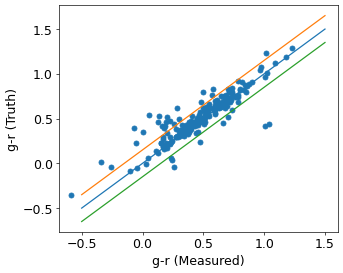

In [23]:
plt.scatter(meas_cat['mag'].data[:, 0] - meas_cat['mag'].data[:, 1], 
            lsbg_cat['mags'].data[:, 0] - lsbg_cat['mags'].data[:, 1])

x = np.linspace(-0.5, 1.5)
plt.plot(x, x)
plt.plot(x, x + 0.15)
plt.plot(x, x - 0.15)

plt.xlabel('g-r (Measured)')
plt.ylabel('g-r (Truth)')